## Modelling time-dependent acquisition of positional information

### Modelling dynamics in a single cell

In this first notebook, we simulate a toy-model implementing the dynamics of  a simple bistable network in a single cell, under the control of an external morphogen.  The network is made of a single gene activating its own transcription. A time-varying morphogen can also control the transcription of this gene in an additive way. The equation for this system is

\begin{equation}
\frac{dP}{dt}=M(t)+r\frac{P^n}{P^n+P_0^n}-P
\end{equation}

The left hand side of this equation describes the rate of change for the concentration of protein P that we impose.  $r P^n/(P^n+P_0^n )$ is the production rate of $P$, and $-P$ represents the degradation of P. We use here a Hill function for autoactivation, and assume that proteins are degraded with a constant rate (rescaled to $1$). A self-activating gene is well-known to produce bistable behaviour, i.e. at steady state, the system can exhibit two states, one with $P=0$ and another one with high $P$. Many biological systems indeed use this motif to define distinct cell fates (e.g. terminal selector genes). The third term $M(t)$ describes the morphogen influence, and we assume that it acts in an additive way by increasing the production rate of $P$. We include a time-dependency with the goal of studying how the dynamics of the morphogen influences the final fate of the system.

**Note:**
<br>
We make several classical modelling approximations: we model protein concentration with a  single continuous variable, we model self-regulation of the protein with a Hill function, and condense (fast) transcription and translation into a single term.  We give a brief example of stochastic generalization  of the formalism using the $\tau$ leaping algorithm.

In the first code cell of our notebook, we import the standard numerical methods `numpy` and define a function, taking as input arguments the concentrations of a protein $P$ and of a morphogen $M$, and returning the value of the derivative defined in the above equation.

In [1]:
import numpy as np

# Definition of the parameters
dyn_parameters = {
    "r" : 2,  # Maximum production rate
    "n" : 5,  # Hill coefficients
    "p0": 1   # Level of p for half-activation
}

def dynamic(p, morphogen, param):
    
    r = param["r"]; p0 = param["p0"]; n = param["n"]
    dp = morphogen +r*p**n/(p**n+p0**n) -p
    
    return dp

We aim to study how the level of the protein $P$ in a single cell depends on the time evolution of a morphogen $M$. We thus need to define a temporal evolution for the morphogen $M$. We will choose a very simple dynamics where the protein $M$ is expressed at level $M_{max}$, and then suddenly disappears  at time  $t_{0}$. In the second code cell, we define this dynamics, by taking as inputs the current time $t_{0}$ and  $M_{max}$, and returning the corresponding value of the morphogen.

In [2]:
def compute_morphogen(t, t_0, m_max):
    
    m = m_max
    if (t > t_0):    m = 0.0
    
    return m

We now have everything we need to integrate the time course and do our simulations. We define a new function  that will be returning an array of times, and corresponding morphogen and protein concentrations as a function of time corresponding to the simulated differential equation. The following function is an implementation of the Euler algorithm, the simplest numerical integrator. The idea of the Euler algorithm is to notice that the equality

\begin{equation}
P(t+d\tau) \simeq P(t) + d\tau \frac{dP(t)}{dt}
\end{equation}

becomes asymptotically exact as $d\tau$ gets smaller. So if we know $P(t)$ and $\frac{dP(t)}{dt}$, we can get a value for $P(t+d\tau)$, and from there iterate and get a complete time course. The function below is implementing this idea with $d\tau=0.01$.

**Note:**
<br>
The Euler algorithm is potentially imprecise if the time-step $d\tau$ is too big, however its simplicity makes it very convenient to explain basic concepts and for relatively simple simulations as described here. The "rule of thumb" to ensure a proper numerical convergence is to check that when we decrease the time step $d\tau$, the behaviour of the integrated system does not change. To find a good initial value $d\tau$, a good strategy is to identify the presumptive fastest time-scale of the system, then take a much smaller value for $d\tau$. For instance for our differential equation, the time-scale is driven by the degradation rate of $P$, which is $1$ in arbitrary units. We thus choose a much smaller  time step $d\tau=0.01$.

In [3]:
def compute_trajectory(t_0, m_max):
    
    init_time = 0.0 
    total_time = 10.0
    time_step = 0.01  # Time-step of the Euler algorithm
    # Time points array: [0, 0.01, ..., 9.99] 
    times = np.arange(init_time, init_time+total_time, time_step)
    
    p = 0.0  # Initial value of P
    # This list will be filled with the successive values of P(t)
    results = [p]
    # This list will be filled with the successive values of M(t)
    morphogen = [compute_morphogen(init_time, t_0, m_max)]
    
    # We iterate our process until the end of the 'times' array
    for t in times[1:]:
    
        # We compute the value of the morphogen concentration
        morpho = compute_morphogen(t, t_0, m_max)
        # We put this value in the corresponding list
        morphogen.append(morpho)
        
        dp = dynamic(p, morpho, dyn_parameters)  # We compute dP/dt
        p = p +time_step*dp  # We iterate P using the Euler algorithm
        results.append(p)    # We put this value in the corresponding list
        
    return times, morphogen, results   

So far we only defined functions to perform the integration, now we actually integrate the equations, and plot the time course. We compute trajectories here for different values of $t_{0}$ corresponding to different times when the morphogen disappears. After importing the graphical library `matplotlib`, we define a list of times when we want to shut off the morphogen for comparison. Then, we compute the whole trajectories corresponding to those different times, and simply plot them all on the same graph.

**Note:**
<br>
The function that allows us to generate a figure with multiple subplots, `plt.subplots`, can be used in two ways. `fig, ax = plt.subplots()` creates a single figure, `ax` being the unique subplot. `fig, ax = plt.subplots(n,m)` generates a figure with $n \times m$ subplots on $n$ rows and $m$ columns. In that case, `ax` is an array of subplots, and `ax[i,j]` is used to plot the figure on row $i$ and column $j$.

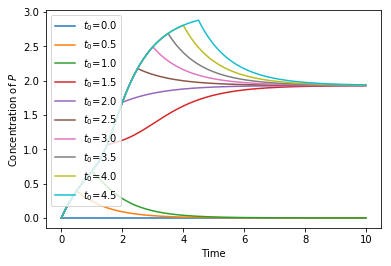

In [4]:
import matplotlib.pyplot as plt
# Display plots in the notebook
%matplotlib inline

fig, ax = plt.subplots()  # We create a figure with 1 subplot

# We iterate over the different times at which M is shut off
times_off = np.arange(0.0, 5.0, 0.5)
for t_0 in times_off:

    # This is where we actually compute the trajectories of P
    times, morphogen, results = compute_trajectory(t_0, 1.0) 
    # We plot the trajectories with different values of t_0
    ax.plot(times, results, label='$t_0$=%s'%t_0)

ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Concentration of $P$')

fig.savefig('Trajectories.png', dpi=300)

We can see that if the morphogen disappears early, $P$ starts increasing before dying when the morphogen disappears; however if the morphogen is expressed for a longer time, we clearly see that $P$ is high enough to actually turn on and sustain its own production, stabilizing in a high state. This is thus a simple model of differentiation relying on a time-dependent morphogen.

An interesting aspect of the simple model displayed here is that we can make a simple connection to classical notions such as Waddington's epigenetic landscape. The reason is that the dynamics of $P$ can be written as the derivative of a potential 

\begin{equation}
\frac{dP}{dt}=-\frac{\partial V(P,M)}{\partial P}
\end{equation}

Such dynamics can be interpreted as a damped system evolving in an energy landscape defined by $V$. Therefore it is worth visualizing $V$ as a function of $M$ to see how this landscape is "tilted" with increasing $M$, leading to a change of fate (corresponding here to different values of $P$). This is done in the following code cell, which, for each value of the morphogen $M$ and each value of $P$ (corresponding to coordinates X and Y) plots the corresponding value of the landscape $V(M,P)$. Warmer colours correspond to higher values of the landscape.

**Note:**
<br>
Since $dP/dt$ is the derivative of $V$, we need to integrate it numerically with respect to $P$, which is  done with the numerical package `scipy`. There is a little subtlety here since our numerical definition of $dP/dt$ is done in the `dynamic` function above, which depends on both the morphogen and the protein. So to integrate with respect to $P$ we need to fix the morphogen, and for this we use the so-called `lambda` operator to compactly redefine a new function gcomputing $dP/dt$  as a function of $P$ for a fixed value of the morphogen.

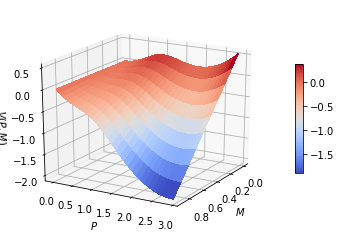

In [5]:
from scipy.integrate import quad
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

# X corresponds to morphogen concentrations
X_lin = np.arange(0.0, 1.0, 0.1)
nx = len(X_lin)
# Y corresponds to protein concentrations
Y_lin = np.arange(0.0, 3.0, 0.1)
ny = len(Y_lin)
X, Y = np.meshgrid(X_lin, Y_lin)
# Z corresponds to the potential V(M,P)
Z = np.zeros((ny, nx))

for i in range(nx):
    
    # Derivative of the potential with fixed morphogen
    g = lambda p: -dynamic(p, X_lin[i], dyn_parameters)
    
    for j in range(ny):
        
        # Integration of the potential
        value, error = quad(g, 0, Y_lin[j])
        Z[j,i] = value

# We specify the 3D plot by adding the '3d' keyword
fig, ax = plt.subplots(subplot_kw={"projection":"3d"})

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=15)
ax.view_init(elev=20, azim=30)
ax.set_xlabel('$M$')
ax.set_ylabel('$P$')
ax.set_zlabel('$V(P,M)$')

fig.savefig('Landscape.png', dpi=300)

Lastly, this example is simple enough to study in a straightforward way what happens if we include biological noise. We will use the $\tau$-leaping approximation to integrate $P$ as a function of time with the modified stochastic equation

\begin{equation}
P(t+d\tau) \simeq P(t) + d\tau (M(t)+r\frac{P^n}{P^n+P_0^n}-P)+\left(\sqrt{dt/\Omega} \sqrt{M(t)+r\frac{P^n}{P^n+P_0^n}+P}\right) \mathcal{N}(0,1)
\end{equation}

In the previous equation, $\mathcal{N}(0,1)$ represents a Gaussian random number with average $0$ and variance $1$, and $\Omega$ is a concentration scale defining the typical maximal number of proteins in the system. We can make minimal modifications to functions defined previously to perform the stochastic integration, and vary the typical concentration scale $\Omega$ to increase or decrease the noise value.

**Note:**
<br>
The above equation can be understood in the following way: the very first equation of this notebook can be interpreted as the continuous version of a stochastic system where protein $P$ is produced with a Poisson rate $\rho(t)=M(t)+r\frac{P^n}{P^n+P_0^n}$ and degraded with a Poisson rate $\delta(t)=P(t)$. This means that during a small interval $[t,t+d\tau]$, there are typically $\rho(t)d\tau$ proteins produced (resp.  $\delta (t)d\tau$ proteins degraded), and for a Poisson process we know that the variance is equal to the mean, so that variance is $\rho(t)d\tau$ as well for production (resp. $\delta (t)d\tau$ for degradation). The $\tau$-leaping algorithm approximates those Poisson processes with Gaussian processes when the rates are big enough, which allows to write that 

\begin{equation}
P(t+d\tau) \simeq P(t)+\mathcal{N_\rho}(\rho(t)d\tau,\rho(t)d\tau)-\mathcal{N_\delta}(\delta(t)d\tau,\delta(t)d\tau)
\end{equation}

where $\mathcal{N}(a,b)$ is used to indicate a random Gaussian number of average $a$ and variance $b$. The minus sign in front of $\mathcal{N_\delta}$ indicates that this process corresponds to a degradation. The last step is to write that for two independent Gaussian numbers $\mathcal{N}_x,\mathcal{N}_y$:

\begin{equation}
\mathcal{N}_x(a,b)-\mathcal{N}_y(c,d)=a-c+\mathcal{N}(0,b+d)=a-c+\sqrt{b+d}\mathcal{N}(0,1)
\end{equation}

which comes from the fact that the sum of two independent Gaussian numbers is the sum of their average plus a Gaussian number with average $0$ and variance equal to the sum of variances, and finally rescaling the last Gaussian number to express it as a function of $\mathcal{N}(0,1)$.
Lastly, the reason why we can extract a typical concentration scale $\Omega$ comes from the fact that the differential equation is invariant with respect to the rescaling $P\rightarrow \Omega P$, $M\rightarrow \Omega M$, $P_0 \rightarrow \Omega P_0$, $r \rightarrow \Omega r$. This means that we can define a typical concentration $\Omega$ for $P$, and rescale the differential equation using the previous rescaling without changing the continuous dynamics. With $r=2$ as assumed in our notebook, $\Omega$ represents the half maximum number of proteins $P$. When computing the $\tau$-leaping version of the equation, if we perform the same rescaling, there is a term $1/\sqrt{\Omega}$ left in front of the noise term. Intuitively, the smaller $\Omega$, the bigger this term, consistent with the intuition that the effective noise "increases" as the number of molecules in the system decreases.

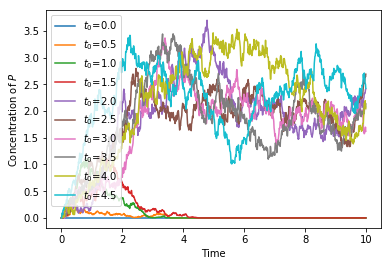

In [6]:
def compute_noise(p, morphogen, param):
    
    r = param["r"]; p0 = param["p0"]; n = param["n"]
    noise = np.random.normal()
    intensity = np.sqrt(morphogen +r*p**n/(p**n+p0**n) +p)
    
    return noise*intensity


def compute_trajectory_stat(t_0, m_max, typical_concentration):
    
    init_time = 0.0 
    total_time = 10.0
    time_step = 0.01 
    times = np.arange(init_time, init_time+total_time, time_step)
    
    p = 0.0
    results=[p]
    morphogen=[compute_morphogen(init_time, t_0, m_max)]
    
    for t in times[1:]:
        
        morpho = compute_morphogen(t, t_0, m_max)
        morphogen.append(morpho)
        
        dp = dynamic(p, morpho, dyn_parameters)
        noise = np.sqrt(time_step/typical_concentration)*compute_noise(p, morpho, dyn_parameters)
        p = p +time_step*dp +float(noise)
        if (p < 0.0):    p = 0.0
        results.append(p)
        
    return times, morphogen, results


fig, ax = plt.subplots()

for t_0 in times_off:
    times, morphogen, results = compute_trajectory_stat(t_0, 1.0, 10.0)
    ax.plot(times, results, label='$t_0$=%s'%t_0)

ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Concentration of $P$')

fig.savefig('Noise_10.png', dpi=300)